#### ISOT

In [1]:
import numpy as np
import pandas as pd
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
import tensorflow_hub as hub
import tensorflow_text
import tldextract  
import warnings
warnings.filterwarnings('ignore')

from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split,StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve, roc_auc_score,f1_score,precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from imblearn.over_sampling import SMOTE,ADASYN
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import re

from collections import Counter
import nltk 
import spacy
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from wordcloud import WordCloud, ImageColorGenerator,STOPWORDS
import gensim
from gensim.parsing.preprocessing import STOPWORDS as gensim_stopwords
import copy
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,LancasterStemmer
from pprint import pprint


import tensorflow as tf
import bert
from tensorflow.keras.models import  Model
from tqdm import tqdm
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense, Dropout, Activation,Embedding,Flatten,LSTM,Bidirectional
from tensorflow.keras.layers import Reshape,Conv1D, MaxPooling1D, Concatenate,BatchNormalization,GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.backend import clear_session



pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', 200)

import warnings
warnings.filterwarnings('ignore')

2022-08-01 21:28:01.340069: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-01 21:28:02.400848: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/software/ada/python/anaconda/2020.11/3.8/lib:/gpfs/software/ada/cuda/10.2.89/lib64:/gpfs/software/ada/cuda/10.2.89/lib/lib64
2022-08-01 21:28:02.400907: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading 

In [2]:
isot_full_df = pd.read_csv("Updated//ISOT_Combined_FullData.csv")

In [3]:
df = isot_full_df[isot_full_df['fulltext'].notna()]

In [4]:
## Shuffling the rows
df = df.sample(frac=1)

In [7]:
X=df[['fulltext']]
y=df[['class']]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=0)

In [9]:
bert_layer=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",trainable=True)

2022-08-01 21:30:50.364437: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/software/ada/python/anaconda/2020.11/3.8/lib:/gpfs/software/ada/cuda/10.2.89/lib64:/gpfs/software/ada/cuda/10.2.89/lib/lib64
2022-08-01 21:30:50.364819: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/software/ada/python/anaconda/2020.11/3.8/lib:/gpfs/software/ada/cuda/10.2.89/lib64:/gpfs/software/ada/cuda/10.2.89/lib/lib64
2022-08-01 21:30:50.365122: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH

In [10]:
MAX_SEQ_LEN=256
input_word_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,name="segment_ids")

def get_masks(tokens, max_seq_length):
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))

def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [11]:
#Create the tokenizer with the BERT layer and import it tokenizer using the original vocab file.
FullTokenizer=bert.bert_tokenization.FullTokenizer

vocab_file=bert_layer.resolved_object.vocab_file.asset_path.numpy()

do_lower_case=bert_layer.resolved_object.do_lower_case.numpy()

tokenizer=FullTokenizer(vocab_file,do_lower_case)

def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens,)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

In [12]:
def create_single_input(sentence,MAX_LEN):
    stokens = tokenizer.tokenize(sentence)
    stokens = stokens[:MAX_LEN]
    stokens = ["[CLS]"] + stokens + ["[SEP]"]
 
    ids = get_ids(stokens, tokenizer, MAX_SEQ_LEN)
    masks = get_masks(stokens, MAX_SEQ_LEN)
    segments = get_segments(stokens, MAX_SEQ_LEN)

    return ids,masks,segments

def create_input_array(sentences):
    input_ids, input_masks, input_segments = [], [], []
    for sentence in tqdm(sentences,position=0, leave=True):
        ids,masks,segments=create_single_input(sentence,MAX_SEQ_LEN-2)
        input_ids.append(ids)
        input_masks.append(masks)
        input_segments.append(segments)
    return [np.asarray(input_ids, dtype=np.int32), 
                    np.asarray(input_masks, dtype=np.int32), 
                    np.asarray(input_segments, dtype=np.int32)]

In [13]:
train_sentences=X_train.fulltext.values
train_y = y_train.values
train_inputs=create_input_array(train_sentences)

# test_sentences=X_test.fulltext.values
# test_y = y_test.values
# test_inputs=create_input_array(test_sentences)

100%|██████████| 30616/30616 [02:41<00:00, 189.44it/s]


In [14]:
X_train.head(2)

,fulltext
1844,McCain calls on Trump to help Ukraine against Russia attack Senate Armed Services Committee Chairman John McCain asked President Donald Trump on Thursday to help Ukraine defend itself against an i...
6201,WATCH: Mike Pence Went To See ‘Hamilton’ And Got Booed By The Whole Theatre Mike Pence took time off from organizing Trump s transition efforts to catch a musical on Broadway but if he thought ...


In [17]:
from tensorflow.keras.models import load_model
new_model = load_model('outputs//isot_dl_bert//model_ISOT_LSTM_BERT.h5',custom_objects={'KerasLayer':hub.KerasLayer})

In [18]:
y_pred=new_model.predict(train_inputs)
ytrue = y_train.values
y_pred2 = np.array((y_pred > 0.5).astype(int)[:,0])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
957/957 [==============================] - 1832s 2s/step


In [19]:
precision = precision_score(ytrue, y_pred2)
recall = recall_score(ytrue, y_pred2)
f1score = f1_score(ytrue, y_pred2)
print("Accuracy score : {}".format(accuracy_score(ytrue, y_pred2)))
print('precision =',precision)
print('recall =',recall)
print('f1score =',f1score)
print(confusion_matrix(ytrue, y_pred2))
print(classification_report(ytrue, y_pred2))

Accuracy score : 0.9957865168539326
precision = 0.991541687397825
recall = 0.9992836676217765
f1score = 0.995397623889543
[[16537   119]
 [   10 13950]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     16656
           1       0.99      1.00      1.00     13960

    accuracy                           1.00     30616
   macro avg       1.00      1.00      1.00     30616
weighted avg       1.00      1.00      1.00     30616



In [21]:
train_df=pd.concat([X_train, y_train], axis=1)

In [22]:
train_df.head(2)

,fulltext,class
1844,McCain calls on Trump to help Ukraine against Russia attack Senate Armed Services Committee Chairman John McCain asked President Donald Trump on Thursday to help Ukraine defend itself against an i...,0
6201,WATCH: Mike Pence Went To See ‘Hamilton’ And Got Booed By The Whole Theatre Mike Pence took time off from organizing Trump s transition efforts to catch a musical on Broadway but if he thought ...,1


In [28]:
df[['fulltext','class']].loc[1844]

fulltext    McCain calls on Trump to help Ukraine against Russia attack Senate Armed Services Committee Chairman John McCain asked President Donald Trump on Thursday to help Ukraine defend itself against an i...
class                                                                                                                                                                                                             0
Name: 1844, dtype: object

In [29]:
#combining predictions with truth class labels in test_filtered dataframe
train_df.insert(len(train_df.columns),'pred',y_pred2)
train_df.head(2)

,fulltext,class,pred
1844,McCain calls on Trump to help Ukraine against Russia attack Senate Armed Services Committee Chairman John McCain asked President Donald Trump on Thursday to help Ukraine defend itself against an i...,0,0
6201,WATCH: Mike Pence Went To See ‘Hamilton’ And Got Booed By The Whole Theatre Mike Pence took time off from organizing Trump s transition efforts to catch a musical on Broadway but if he thought ...,1,1


In [30]:
#misclassified samples
misclassified_df = df.loc[train_df[train_df['class']!=train_df['pred']].index, :]  # works
misclassified_df.shape

(129, 8)

In [31]:
misclassified_df.head(100)

,title,text,subject,date,class,title_length,body_length,fulltext
4529,"ANGELA MERKEL Running For Re-Election Makes Stunning Announcement To BAN BURKAS, After Flooding Nation With 2 Million (Mostly Muslim) Migrants",ANGELA Merkel today completed an astonishing U-turn as she formally endorsed a full burka ban following a backlash over her open-door migration policies.The German chancellor made the comments at ...,politics,"Dec 6, 2016",1,142,1269,"ANGELA MERKEL Running For Re-Election Makes Stunning Announcement To BAN BURKAS, After Flooding Nation With 2 Million (Mostly Muslim) Migrants ANGELA Merkel today completed an astonishing U-turn a..."
9256,Must see TV: why gutting NAFTA unlikely to create U.S. jobs,"Both U.S. presidential candidates routinely criticize free-trade deals they blame for the loss of American jobs. But tweaking the North American Free Trade Agreement (NAFTA), as Hillary Clinton ha...",politicsNews,"October 25, 2016",0,59,7225,Must see TV: why gutting NAFTA unlikely to create U.S. jobs Both U.S. presidential candidates routinely criticize free-trade deals they blame for the loss of American jobs. But tweaking the North ...
11797,How parents of adopted children foiled a U.S. Republican tax proposal,Charles “Chuck” Johnson is not the kind of foot soldier in the army of lobbyists that House of Representatives Speaker Paul Ryan warned would descend on Washington to fight the biggest overhaul of...,politicsNews,"November 30, 2017",0,69,4478,How parents of adopted children foiled a U.S. Republican tax proposal Charles “Chuck” Johnson is not the kind of foot soldier in the army of lobbyists that House of Representatives Speaker Paul Ry...
36838,Rainbow raids: Egypt launches its widest anti-gay crackdown yet,"Sarah Hegazy has been jailed, beaten by inmates, and could face a life sentence in an Egyptian prison if found guilty of promoting sexual deviancy and other charges tied to her alleged crime: wa...",worldnews,"October 6, 2017",0,63,7769,"Rainbow raids: Egypt launches its widest anti-gay crackdown yet Sarah Hegazy has been jailed, beaten by inmates, and could face a life sentence in an Egyptian prison if found guilty of promoting ..."
30266,Vietnam dissident's daughter calls on Melania Trump for help,"The 10-year-old daughter of a jailed Vietnamese blogger, Mother Mushroom , has appealed to U.S. First Lady Melania Trump to help win her mother s release ahead of President Donald Trump s visit t...",worldnews,"October 27, 2017",0,60,2464,"Vietnam dissident's daughter calls on Melania Trump for help The 10-year-old daughter of a jailed Vietnamese blogger, Mother Mushroom , has appealed to U.S. First Lady Melania Trump to help win h..."
12387,"From a river town in Slovenia to Trump Tower, and the White House?","If Melania Trump succeeds Michelle Obama as First Lady, she may trace her road to the White House back to 1987 and a chance encounter in the capital of her native Slovenia. “I was leaving a fashio...",politicsNews,"February 12, 2016",0,66,5084,"From a river town in Slovenia to Trump Tower, and the White House? If Melania Trump succeeds Michelle Obama as First Lady, she may trace her road to the White House back to 1987 and a chance encou..."
30938,"Trump? Clinton? Many young Americans prefer giant meteor, poll finds",Young Americans are so dissatisfied with their choices in this presidential election that nearly one in four told an opinion poll they would rather have a giant meteor destroy the Earth than see D...,politicsNews,"October 18, 2016",0,68,2379,"Trump? Clinton? Many young Americans prefer giant meteor, poll finds Young Americans are so dissatisfied with their choices in this presidential election that nearly one in four told an opinion po..."
15922,"Uber, Grab to tighten up on deliveries in Philippines amid drug concerns","Ride-hailing platforms Uber [UBER.UL] and Grab have agreed to stop their drivers from delivering unchecked packages on behalf of customers, in response to government concerns they

In [32]:
misclassified_df['class'].value_counts()

0    119
1     10
Name: class, dtype: int64

In [39]:
misclassified_df.insert(0, 'New_ID', range(1, 1 + len(misclassified_df)))
misclassified_df.head(100)

,New_ID,title,text,subject,date,class,title_length,body_length,fulltext
4529,1,"ANGELA MERKEL Running For Re-Election Makes Stunning Announcement To BAN BURKAS, After Flooding Nation With 2 Million (Mostly Muslim) Migrants",ANGELA Merkel today completed an astonishing U-turn as she formally endorsed a full burka ban following a backlash over her open-door migration policies.The German chancellor made the comments at ...,politics,"Dec 6, 2016",1,142,1269,"ANGELA MERKEL Running For Re-Election Makes Stunning Announcement To BAN BURKAS, After Flooding Nation With 2 Million (Mostly Muslim) Migrants ANGELA Merkel today completed an astonishing U-turn a..."
9256,2,Must see TV: why gutting NAFTA unlikely to create U.S. jobs,"Both U.S. presidential candidates routinely criticize free-trade deals they blame for the loss of American jobs. But tweaking the North American Free Trade Agreement (NAFTA), as Hillary Clinton ha...",politicsNews,"October 25, 2016",0,59,7225,Must see TV: why gutting NAFTA unlikely to create U.S. jobs Both U.S. presidential candidates routinely criticize free-trade deals they blame for the loss of American jobs. But tweaking the North ...
11797,3,How parents of adopted children foiled a U.S. Republican tax proposal,Charles “Chuck” Johnson is not the kind of foot soldier in the army of lobbyists that House of Representatives Speaker Paul Ryan warned would descend on Washington to fight the biggest overhaul of...,politicsNews,"November 30, 2017",0,69,4478,How parents of adopted children foiled a U.S. Republican tax proposal Charles “Chuck” Johnson is not the kind of foot soldier in the army of lobbyists that House of Representatives Speaker Paul Ry...
36838,4,Rainbow raids: Egypt launches its widest anti-gay crackdown yet,"Sarah Hegazy has been jailed, beaten by inmates, and could face a life sentence in an Egyptian prison if found guilty of promoting sexual deviancy and other charges tied to her alleged crime: wa...",worldnews,"October 6, 2017",0,63,7769,"Rainbow raids: Egypt launches its widest anti-gay crackdown yet Sarah Hegazy has been jailed, beaten by inmates, and could face a life sentence in an Egyptian prison if found guilty of promoting ..."
30266,5,Vietnam dissident's daughter calls on Melania Trump for help,"The 10-year-old daughter of a jailed Vietnamese blogger, Mother Mushroom , has appealed to U.S. First Lady Melania Trump to help win her mother s release ahead of President Donald Trump s visit t...",worldnews,"October 27, 2017",0,60,2464,"Vietnam dissident's daughter calls on Melania Trump for help The 10-year-old daughter of a jailed Vietnamese blogger, Mother Mushroom , has appealed to U.S. First Lady Melania Trump to help win h..."
12387,6,"From a river town in Slovenia to Trump Tower, and the White House?","If Melania Trump succeeds Michelle Obama as First Lady, she may trace her road to the White House back to 1987 and a chance encounter in the capital of her native Slovenia. “I was leaving a fashio...",politicsNews,"February 12, 2016",0,66,5084,"From a river town in Slovenia to Trump Tower, and the White House? If Melania Trump succeeds Michelle Obama as First Lady, she may trace her road to the White House back to 1987 and a chance encou..."
30938,7,"Trump? Clinton? Many young Americans prefer giant meteor, poll finds",Young Americans are so dissatisfied with their choices in this presidential election that nearly one in four told an opinion poll they would rather have a giant meteor destroy the Earth than see D...,politicsNews,"October 18, 2016",0,68,2379,"Trump? Clinton? Many young Americans prefer giant meteor, poll finds Young Americans are so dissatisfied with their choices in this presidential election that nearly one in four told an opinion po..."
15922,8,"Uber, Grab to tighten up on deliveries in Philippines amid drug concerns","Ride-hailing platforms Uber [UBER.UL] and Grab have agreed to stop their drivers from delivering unchecked packages on behalf of customers, in response to g

#### Misclassified or wrong predictions of  news count with Domain Based 

In [40]:
df_domain_misclassfd_count=misclassified_df.pivot_table(index='subject',columns = 'class', values = 'New_ID', 
                                          aggfunc='count').fillna(0).astype(int)

In [41]:
wrongpred_real_domain=df_domain_misclassfd_count[0].sort_values(ascending=False).head(15)
wrongpred_fake_domain=df_domain_misclassfd_count[1].sort_values(ascending=False).head(15)

<AxesSubplot:xlabel='subject'>

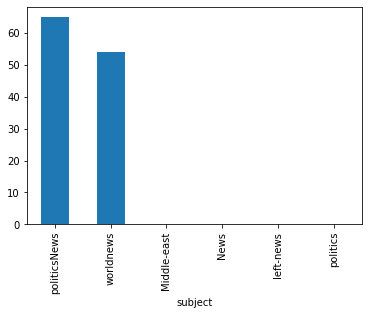

In [42]:
wrongpred_real_domain.plot(kind='bar')

<AxesSubplot:xlabel='subject'>

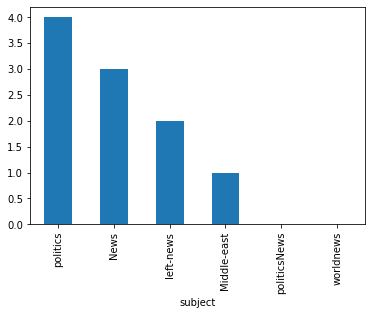

In [43]:
wrongpred_fake_domain.plot(kind='bar')